To perform registration with `DiffDRR`, we do the following:

1. Obtain a target X-ray (this is the image whose pose parameters we wish to recovery)
2. Initialize a moving DRR module from a random camera pose
3. Measure the loss between the target X-ray and the moving DRR (we use normalized negative cross-correlation)
4. Backpropogate this loss to the pose parameters of the moving DRR and render from the new pose
5. Repeat Steps 3-4 until the loss has converged

## 1. Generate a target X-ray

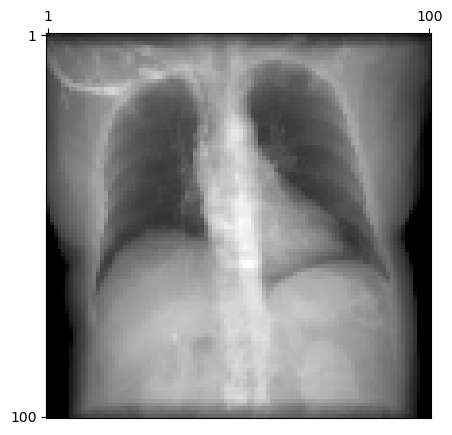

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.metrics import (
    MultiscaleNormalizedCrossCorrelation2d,
    NormalizedCrossCorrelation2d,
)
from diffdrr.registration import Registration
from diffdrr.visualization import plot_drr

# Make the ground truth X-ray
SDD = 1020.0
HEIGHT = 100
DELX = 4.0

subject = load_example_ct()
true_params = {
    "sdr": SDD,
    "alpha": 0.0,
    "beta": 0.0,
    "gamma": 0.0,
    "bx": 0.0,
    "by": 850.0,
    "bz": 0.0,
}
device = "cuda" if torch.cuda.is_available() else "cpu"

drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
rotations = torch.tensor(
    [
        [
            true_params["alpha"],
            true_params["beta"],
            true_params["gamma"],
        ]
    ]
).to(device)
translations = torch.tensor(
    [
        [
            true_params["bx"],
            true_params["by"],
            true_params["bz"],
        ]
    ]
).to(device)
ground_truth = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZXY",
)

plot_drr(ground_truth)
plt.show()

## 2. Initialize a moving DRR from a random pose

In [ ]:
from diffdrr.pose import convert


def pose_from_carm(sid, tx, ty, alpha, beta, gamma):
    rot = torch.tensor([[alpha, beta, gamma]])
    xyz = torch.tensor([[tx, sid, ty]])
    return convert(rot, xyz, parameterization="euler_angles", convention="ZXY")

gt_pose = convert(rotations, translations, parameterization="euler_angles", convention="ZXY")

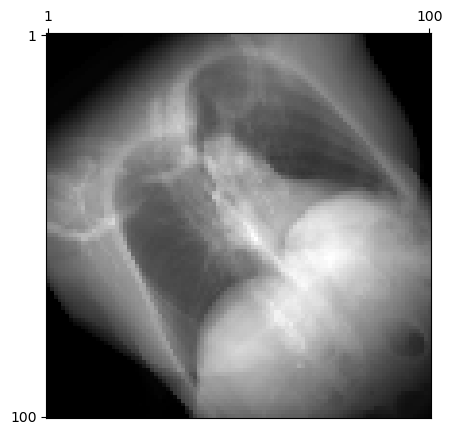

(tensor([[-0.4367,  0.5823, -0.4607]], device='cuda:0'),
 tensor([[ 25.1167, 849.3047,   6.7047]], device='cuda:0'))

In [ ]:
#| code-fold: true
# Make a random DRR
np.random.seed(5)


def get_initial_parameters(true_params):
    alpha = true_params["alpha"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    beta = true_params["beta"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    bx = true_params["bx"] + np.random.uniform(-30.0, 30.0)
    by = true_params["by"] + np.random.uniform(-30.0, 30.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 30.0)
    pose = pose_from_carm(by, bx, bz, alpha, beta, gamma).cuda()
    rotations, translations = pose.convert("euler_angles", "ZXY")
    return rotations, translations, pose


rotations, translations, pose = get_initial_parameters(true_params)
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
with torch.no_grad():
    est = drr(pose)
plot_drr(est)
plt.show()

rotations, translations

## 3. Measure the loss between the target X-ray and moving DRR

We start by measuring the initial loss between the two images.

In [ ]:
criterion = NormalizedCrossCorrelation2d()
criterion(ground_truth, est).item()

0.4227702021598816

If the negative normalized cross-correlation is greater than 0.999, we say the target and moving DRR have converged.

## 4. Backpropogate the loss to the moving DRR parameters

We also use this example to show how different optimizers affect the outcome of registration.
The parameters we tweak are

- `lr_rotations`: learning rate for rotation parameters
- `lr_translations`: learning rate for translation parameters
- `momentum`: momentum for stochastic gradient descent
- `dampening`: dampening for stochastic gradient descent

In [ ]:
def optimize(
    reg: Registration,
    ground_truth,
    lr_rotations=5e-2,
    lr_translations=5e1,
    momentum=0,
    dampening=0,
    n_itrs=250,
    optimizer="sgd",  # 'sgd' or `adam`
):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(
            [
                {"params": [reg._rotation], "lr": lr_rotations},
                {"params": [reg._translation], "lr": lr_translations},
            ],
            momentum=momentum,
            dampening=dampening,
            maximize=True,
        )
    else:
        optimizer = torch.optim.Adam(
            [
                {"params": [reg._rotation], "lr": lr_rotations},
                {"params": [reg._translation], "lr": lr_translations},
            ],
            maximize=True,
        )

    params = []
    losses = []
    for itr in (pbar := tqdm(range(n_itrs), ncols=100)):
        # Save the current set of parameters
        alpha, beta, gamma = reg.rotation.squeeze().tolist()
        bx, by, bz = reg.translation.squeeze().tolist()
        params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

        # Run the optimization loop
        optimizer.zero_grad()
        estimate = reg()
        loss = criterion(ground_truth, estimate)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
        pbar.set_description(f"{loss.item():06f}")

        if loss > 0.999:
            tqdm.write(f"Converged in {itr} iterations")
            break

    plt.show()
    df = pd.DataFrame(params, columns=["alpha", "beta", "gamma", "bx", "by", "bz"])
    df["loss"] = losses
    return df

## Run the optimization algorithm

In [ ]:
# Base SGD
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_base = optimize(reg, ground_truth)
print(params_base["loss"].iloc[-1])
del drr

# SGD + momentum
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_momentum = optimize(reg, ground_truth, momentum=5e-1)
print(params_momentum["loss"].iloc[-1])
del drr

# SGD + momentum + dampening
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_momentum_dampen = optimize(reg, ground_truth, momentum=5e-1, dampening=1e-3)
print(params_momentum_dampen["loss"].iloc[-1])
del drr

# Adam
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_adam = optimize(reg, ground_truth, 1e-1, 1e1, optimizer="adam")
print(params_adam["loss"].iloc[-1])
del drr

0.999050:  76%|██████████████████████████████████████▉            | 191/250 [00:03<00:01, 48.92it/s]


Converged in 191 iterations
0.9990504384040833


0.999136:  28%|██████████████▊                                     | 71/250 [00:01<00:03, 59.33it/s]


Converged in 71 iterations
0.9991360902786255


0.999118:  31%|████████████████                                    | 77/250 [00:01<00:02, 59.62it/s]


Converged in 77 iterations
0.9991179704666138


0.999281:  19%|█████████▉                                          | 48/250 [00:00<00:03, 56.47it/s]

Converged in 48 iterations
0.999281108379364


## Visualize the parameter updates

Note that differences that between different optimization algorithms can be seen in the motion in the DRRs!

In [ ]:
#| code-fold: true
from base64 import b64encode

from IPython.display import HTML, display

from diffdrr.visualization import animate


def animate_in_browser(df, skip=1):
    n = MAX_LENGTH - len(df)
    df = pd.concat([df, df.iloc[[-1] * n]]).iloc[::skip]

    out = animate(
        "<bytes>",
        df,
        drr,
        ground_truth=ground_truth,
        verbose=True,
        device=device,
        extension=".webp",
        duration=30,
        parameterization="euler_angles",
        convention="ZXY",
    )
    display(HTML(f"""<img src='{"data:img/gif;base64," + b64encode(out).decode()}'>"""))


MAX_LENGTH = max(
    map(
        len,
        [
            params_base,
            params_momentum,
            params_momentum_dampen,
            params_adam,
        ],
    )
)
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)

In [ ]:
animate_in_browser(params_base)

Precomputing DRRs: 100%|█████████████████| 192/192 [00:31<00:00,  6.15it/s]


In [ ]:
animate_in_browser(params_momentum)

Precomputing DRRs: 100%|█████████████████| 192/192 [00:32<00:00,  5.98it/s]


In [ ]:
animate_in_browser(params_momentum_dampen)

Precomputing DRRs: 100%|█████████████████| 192/192 [00:31<00:00,  6.13it/s]


In [ ]:
animate_in_browser(params_adam)

Precomputing DRRs: 100%|█████████████████| 192/192 [00:32<00:00,  5.98it/s]


## Visualize the optimization trajectories

In [ ]:
import pyvista

from diffdrr.visualization import drr_to_mesh, img_to_mesh

pyvista.start_xvfb()


def df_to_mesh(drr, df):
    pts = []
    for idx in tqdm(range(len(df))):
        rot = torch.tensor(df.iloc[idx][["alpha", "beta", "gamma"]].tolist())
        xyz = torch.tensor(df.iloc[idx][["bx", "by", "bz"]].tolist())
        pose = convert(
            rot.unsqueeze(0),
            xyz.unsqueeze(0),
            parameterization="euler_angles",
            convention="ZXY",
        ).cuda()
        with torch.no_grad():
            source, _ = drr.detector(pose, None)
        pts.append(source.squeeze().cpu().tolist())
    return *img_to_mesh(drr, pose), lines_from_points(np.array(pts))


def lines_from_points(points):
    """Given an array of points, make a line set"""
    poly = pyvista.PolyData()
    poly.points = points
    cells = np.full((len(points) - 1, 3), 2, dtype=np.int_)
    cells[:, 1] = np.arange(0, len(points) - 1, dtype=np.int_)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int_)
    poly.lines = cells
    return poly.tube(radius=3)


plotter = pyvista.Plotter()
ct = drr_to_mesh(drr.subject, "surface_nets", 225, verbose=False)
plotter.add_mesh(ct)

camera, detector, texture, principal_ray, points = df_to_mesh(drr, params_base)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="lime")

camera, detector, texture, principal_ray, points = df_to_mesh(drr, params_momentum)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="deeppink", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="deeppink")

camera, detector, texture, principal_ray, points = df_to_mesh(
    drr, params_momentum_dampen
)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="darkorange", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="darkorange")

camera, detector, texture, principal_ray, points = df_to_mesh(drr, params_adam)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="cyan", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_mesh(points, color="cyan")

camera, detector, texture, principal_ray = img_to_mesh(drr, gt_pose)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="black", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()

plotter.export_html("registration.html")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 637.63it/s]


In [ ]:
from IPython.display import IFrame

IFrame("registration.html", height=500, width=749)